In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matlab.engine
import matlab
import scipy.sparse
import pandas as pd
from itertools import product
from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from regain import datasets; reload(datasets)
from regain.admm import graph_lasso_; reload(graph_lasso_);
from regain.admm import time_graph_lasso_; reload(time_graph_lasso_);
from regain.admm import latent_graph_lasso_; reload(latent_graph_lasso_);
from regain.admm import latent_time_graph_lasso_; reload(latent_time_graph_lasso_);
from regain import utils; reload(utils)
import time

# Run experiments

### Prepare datasets

In [9]:
n_dims = np.sqrt(np.logspace(2,5,10)).astype(int)
n_times = [20,50,100]

In [394]:
n_samples = 1000
n_dim_lat = 3

np.random.seed(42)
data = {(dim,T) : datasets.generate_dataset(
    mode='fixed', n_samples=n_samples, n_dim_lat=dim / 10., n_dim_obs=dim,  T=T, epsilon=1e-2)
    for dim, T in (product(n_dims, [2]))}

### Cross validate

In [20]:
def cross_validate(data_grid, model='bo', **kwargs):
    mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
        eta=1000, alpha=0.1, beta=0.5,
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=250, rho=1./ np.sqrt(data_grid.shape[0]))
    cv = ShuffleSplit()
    if model == 'gs':
        ltgl = GridSearchCV(mdl, kwargs['param_grid'], cv=cv, verbose=True)
    else:
        domain = [
            {'name': 'tau', 'type': 'continuous', 'domain': (-2, -1)},
            # {'name': 'alpha', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
            # {'name': 'beta', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
            # {'name': 'eta', 'type': 'continuous', 'domain': (-2.,np.log10(.5))},
        ]
        ltgl = model_selection.BayesianOptimization(
            mdl, domain=domain, n_jobs=2, acquisition_weight=1, acquisition_jitter=.01,
            acquisition_type='EI', max_iter=200, cv=cv)

    ltgl.fit(data_grid)
    return ltgl.best_params_

In [ ]:
best_params_ = {}
for k, res in data.items():
    print("CV start with: dim=%d, T=%d" % k)
    data_grid = np.array(res.data).transpose(1,2,0)  # to use it later for grid search
    best_params_[k] = cross_validate(
        data_grid, model='gs',param_grid=dict(alpha=[.1], beta=[.5], tau=np.logspace(-2, -1, 20)))

CV start with: dim=100, T=100
Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [289]:
import cPickle as pkl
# with open("best_params_seed_42_rho.pkl", 'wb') as f:
#     pkl.dump(best_params_, f)
with open("best_params_seed_42.pkl", 'rb') as f:
    best_params = pkl.load(f)

# Performances of the different algorithms

In [10]:
def gl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = graph_lasso_.GraphLasso(
        assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(np.array(data_list).shape[1]))
    
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        mdl.set_params(**params).fit(d)
        iters.append(mdl.n_iter_)
        precisions.append(mdl.precision_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)

    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None # utils.error_norm(K_obs, precisions - latents)
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None#utils.error_norm(ells, latents)
    mean_rank_error = None#utils.error_rank(ells, latents)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=mdl)
    return res

def lgl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = latent_graph_lasso_.LatentGraphLasso(
        assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(np.array(data_list).shape[1]))
    
    tic = time.time()
    iters = []
    precisions, latents = [], []
    for d in data_grid.transpose(2,0,1):
        mdl.set_params(**params).fit(d)
        iters.append(mdl.n_iter_)
        precisions.append(mdl.precision_)
        latents.append(mdl.latent_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)
    latents = np.array(latents)

    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = utils.error_norm(K_obs, precisions - latents)
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = utils.error_norm(ells, latents)
    mean_rank_error = utils.error_rank(ells, latents)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=mdl)
    return res

def tgl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = time_graph_lasso_.TimeGraphLasso(
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(np.array(data_list).shape[1]))
    
    tic = time.time()
    ll = mdl.set_params(**params).fit(data_grid)
    tac = time.time()
    iterations = ll.n_iter_
    F1score = utils.structure_error(K, ll.precision_)['f1']
    MSE_observed = None # utils.error_norm(K_obs, ll.precision_ - ll.latent_)
    MSE_precision = utils.error_norm(K, ll.precision_)
    MSE_latent = None # utils.error_norm(ells, ll.latent_)
    mean_rank_error = None # utils.error_rank(ells, ll.latent_)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=ll)
    return res

def ltgl_results(data_grid, K, K_obs, ells, **params):
    
    mdl = latent_time_graph_lasso_.LatentTimeGraphLasso(
        eta=1000,
        bypass_transpose=False, assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5,
        max_iter=500, rho=1./ np.sqrt(np.array(data_list).shape[1]))
    
    tic = time.time()
    ll = mdl.set_params(**params).fit(data_grid)
    tac = time.time()
    iterations = ll.n_iter_
    F1score = utils.structure_error(K, ll.precision_)['f1']
    MSE_observed = utils.error_norm(K_obs, ll.precision_ - ll.latent_)
    MSE_precision = utils.error_norm(K, ll.precision_)
    MSE_latent = utils.error_norm(ells, ll.latent_)
    mean_rank_error = utils.error_rank(ells, ll.latent_)
    
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=ll)
    return res

In [25]:
from sklearn.covariance import GraphLasso
def glasso_results(data_grid, K, K_obs, ells, alpha):
    gl = GraphLasso(alpha=alpha, mode='cd', assume_centered=False, max_iter=300)
    
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        gl.fit(d)
        iters.append(gl.n_iter_)
        precisions.append(gl.precision_)
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)
    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None
 
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=gl)
 
    return res

from rpy2.robjects.packages import importr
glasso = importr('glasso').glasso

def friedman_results(data_grid, K, K_obs, ells, alpha):
    tic = time.time()
    iters = []
    precisions = []
    for d in data_grid.transpose(2,0,1):
        emp_cov = empirical_covariance(d)
        out = glasso(emp_cov, alpha)
        iters.append(int(out[-1][0]))
        precisions.append(np.array(out[1]))
    tac = time.time()
    iterations = np.max(iters)
    precisions = np.array(precisions)
    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None
 
    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=iterations,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None,
               estimator=None)
 
    return res

In [13]:
import sys
sys.path.append("/home/fede/src/TVGL")
import TVGL; reload(TVGL)
import inferGraphL2; reload(inferGraphL2)
from TVGL import tvgl_hallac

def hallac_results(data_grid, K, K_obs, ells, beta, alpha):
    tic = time.time()
    thetaSet, empCovSet, status, gvx = tvgl_hallac(
        data_grid.transpose(2,0,1), lamb=alpha, beta=beta, indexOfPenalty=2)
    tac = time.time()

    if status != "Optimal":
        print "not converged"
    precisions = np.array(thetaSet)
    F1score = utils.structure_error(K, precisions)['f1']
    MSE_observed = None
    MSE_precision = utils.error_norm(K, precisions)
    MSE_latent = None
    mean_rank_error = None

    res = dict(n_dim_obs=K.shape[1],
               time=tac-tic,
               iterations=gvx.n_iter_,
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=status,
               estimator=gvx)

    return res

In [6]:
eng = matlab.engine.start_matlab()
eng.addpath(r'/home/fede/src/slipguru/regain/regain/wrapper/lvglasso/',nargout=0)

def chandresekeran_results(data_grid, K, K_obs, ells, tau, alpha, **whatever):
   
    emp_list = np.array([empirical_covariance(x, assume_centered=True)
                        for x in data_grid.transpose(2,0,1)]).transpose(1,2,0)
    
    n_samples = emp_list.shape[0]
    rho = 1./ np.sqrt(np.array(data_list).shape[1])
    opts = dict(continuation=1, num_continuation=0,eta=np.sqrt(100),muf=1e-6,
                maxiter=500,stoptol=1e-5,over_relax_par=1, mu=n_samples)
#     start_time = time.time()

    # 1. SCIPY
    # from scipy.io import loadmat, savemat
    # savemat("/home/fede/Desktop/details.mat", {'emp_list':emp_list, 'tau':taus[-1], 'alpha':alphas[-1]})
    # loadmat("/home/fede/Desktop/output.mat")
    
    # 2. pymatbridge
    # mlab = Matlab()
    # mlab.start()

    # # single run of ADMM_B
    # # result = mlab.run_func('/home/fede/Downloads/lvglasso-pub/ADMM_B.m', emp_list[...,0], alpha, tau, opts)

    # # insert the ADMM_B.m function in the path
    # mlab.run_code("addpath(genpath('/home/fede/Downloads/lvglasso-pub/'))")

    # result = mlab.run_func("/home/fede/src/slipguru/regain/regain/wrapper/ADMMMA.m",
    #                       emp_list, alpha, tau)
    # mlab.stop()
    # ma_output = Bunch(**result['result'])
    
    # 3. Matlab engine
    result = eng.LVGLASSO(matlab.double(emp_list.tolist()),float(alpha),float(tau),float(rho))
    ma_output = Bunch(**result)

    ma_output.R = np.array(ma_output.R)
    ma_output.S = np.array(ma_output.S)
    ma_output.L = np.array(ma_output.L)
    
    F1score = utils.structure_error(K, ma_output.R + ma_output.L)['f1']
    MSE_observed = utils.error_norm(K_obs, ma_output.R)
    MSE_precision = utils.error_norm(K, ma_output.R + ma_output.L)
    MSE_latent = utils.error_norm(ells, ma_output.L)
    mean_rank_error = utils.error_rank(ells, ma_output.L)
    
    res = dict(n_dim_obs=K.shape[1],
               time=ma_output.elapsed_time,
               iterations=np.max(ma_output.iter),
               F1score=F1score,
               MSE_precision=MSE_precision,
               MSE_observed=MSE_observed,
               MSE_latent=MSE_latent,
               mean_rank_error=mean_rank_error,
               note=None, estimator=ma_output)
 
    return res

In [72]:
# eng.quit()    

In [21]:
import cPickle as pkl
# with open("best_params_seed_42.pkl", 'wb') as f:
#     pkl.dump(best_params_, f)
with open("best_params_seed_42.pkl", 'rb') as f:
    best_params = pkl.load(f)

### Comparison

In [14]:
# prepare dataframe for results
scores = sorted(["F1score", "MSE_precision", "MSE_observed", "MSE_latent","mean_rank_error",'time','iterations'])
cols = pd.MultiIndex.from_product([scores, n_dims], names=('score','dim'))
rows = pd.MultiIndex.from_product([['LTGL', 'GL', 'LVGLASSO', 'TVGL'], n_times], names=('method','time'))

dff = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

In [15]:
dff_ours = dff.copy()

In [16]:
n_dims

array([ 10,  14,  21,  31,  46,  68, 100, 146, 215, 316])

In [514]:
n_samples = 10
n_dim_lat = 10 # int(np.sqrt(n_samples))

np.random.seed(40)
reload(datasets)
data = {(dim, T) : datasets.generate_dataset(
    mode='fixedl1', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-3)
    for dim, T in (product(n_dims, [20]))}

In [229]:
data_grid = np.array(data[(n_dims[2],50)].data).transpose(1,2,0)
K = data[(n_dims[2],50)].thetas
K_obs = data[(n_dims[2],50)].thetas_observed
ells = data[(n_dims[2],50)].ells

In [582]:
# prepare dataframe for results
scores = sorted(["F1score", "MSE_precision", "MSE_observed", "MSE_latent","mean_rank_error",'time','iterations'])
cols = pd.MultiIndex.from_product([scores, n_dims], names=('score','dim'))
rows = pd.MultiIndex.from_product([['LTGL', 'GL', 'TGL', 'LGL'], n_times], names=('method','time'))

dff = pd.DataFrame(columns=cols, index=rows)
idx = pd.IndexSlice

In [578]:
alpha = 0.5
tau = 1.
beta = 0.5
eta = 0.5

In [575]:
from __future__ import print_function
ltgl_res, lgl_res, tgl_res, gl_res = [],[],[],[]
for i, (k, res) in enumerate(data.items()):
    if k[0] != 100:# or k[1] != 50:
        continue
    print("Start with: dim=%d, T=%d (it %d)" % (k[0],k[1], i))
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search
    params = best_params.get(k, dict(alpha=0.2,beta=0.5,tau=0.1))

    print("starting LTGL ...\r", end='')
    res = ltgl_results(data_grid, K, K_obs, ells, 
                       alpha=alpha,#max(params['alpha'], 0.2),
                       beta=beta,#max(params['beta'], 0.2),
                       eta=eta,
                       tau=tau,#min(params['tau'], 0.1),
                       psi='l1')
    dff.loc[idx['LTGL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    ltgl_res.append(res)
    
    print("starting chandresekeran\r", end='')
    res = chandresekeran_results(data_grid, K, K_obs, ells,
                                 tau=1,#min(params['tau'], 0.1),
                                 alpha=.5)#max(params['alpha'], 0.2))
    dff.loc[idx['LGL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    
#     print("starting LGL ...\r", end='')
#     res = lgl_results(data_grid, K, K_obs, ells, 
#                        alpha=.5,#max(params['alpha'], 0.2),
#                        tau=1)#min(params['tau'], 0.1))
#     dff.loc[idx['LGL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    lgl_res.append(res)
    print("starting TGL ...\r", end='')
    res = tgl_results(data_grid, K, K_obs, ells, 
                       alpha=max(params['alpha'], 0.2),
                       beta=max(params['beta'], 0.2)
                     )
    dff.loc[idx['TGL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    tgl_res.append(res)
    print("starting GL ...\r", end='')
    res = gl_results(data_grid, K, K_obs, ells, 
                       alpha=max(params['alpha'], 0.2))
    dff.loc[idx['GL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    gl_res.append(res)

Start with: dim=100, T=20 (it 1)


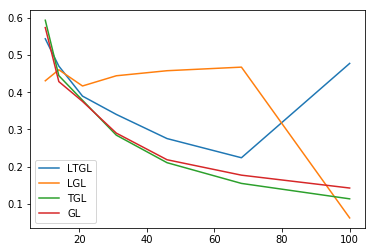

In [577]:
mm = dff.xs("F1score", level='score', axis=1).xs(20, level='time')
for x in mm.index:
    plt.plot(mm.xs(x))
# plt.xscale('log')
plt.legend()
# plt.ylim([0.597,0.600])

In [65]:
# setting 1
alpha = 0.75
tau = 1.
beta = 0.75
eta = 0.5

n_samples = 10
n_dim_lat = 10
T = 20
n_dims = np.sqrt(np.logspace(2,5,10)).astype(int)

np.random.seed(40)
reload(datasets)
data = {(dim, T) : datasets.generate_dataset(
    mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-3, degree=3)
    for dim in n_dims}

In [86]:
# setting 2
alpha = 0.75
tau = 1.
beta = 0.75
eta = 0.5

n_samples = 50
n_dim_lat = 2
T = 100
n_dims = np.sqrt(np.logspace(2,5,10)).astype(int)

np.random.seed(42)
reload(datasets)
data = {(dim, T) : datasets.generate_dataset(
    mode='fixedl1', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-3, degree=3)
    for dim in n_dims}

In [87]:
# n_samples = 10
# n_dim_lat = 10 # int(np.sqrt(n_samples))

# np.random.seed(40)
# reload(datasets)
# data = {(dim, T) : datasets.generate_dataset(
#     mode='fixed', n_samples=n_samples, n_dim_lat=n_dim_lat, n_dim_obs=dim,  T=T, epsilon=1e-3, degree=3)
#     for dim, T in (product(n_dims, [10, 20, 50]))}

In [88]:
for i, (k, res) in enumerate(data.items()):
    if k[0] > 320:# or k[1] != 50:
        continue
    print("Start with: dim=%d, T=%d (it %d)" % (k[0],k[1], i))
    data_list = res.data
    K = res.thetas
    K_obs = res.thetas_observed
    ells = res.ells
    data_grid = np.array(data_list).transpose(1,2,0)  # to use it later for grid search
    dim = k[0]
    
    alpha_ = alpha / 4
    print("starting LTGL ...")
    res = ltgl_results(data_grid, K, K_obs, ells, 
                       alpha=alpha_, beta=beta,
                       tau=tau, eta=eta, psi='l1')
    dff.loc[idx['LTGL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    print("starting Graph Lasso")
    try:
        res = glasso_results(data_grid, K, K_obs, ells, alpha=alpha_)
        
#     res = friedman_results(data_grid, K, K_obs, ells, alpha=max(params['alpha'], 0.2))
        dff.loc[idx['GL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    except:
        pass
#     print("starting hallac")
#     res = hallac_results(data_grid, K, K_obs, ells, beta=beta, alpha=alpha)
#     dff.loc[idx['TVGL', k[1]], idx[:, k[0]]] = [res[x] for x in scores]
    print("starting chandresekeran")
    res = chandresekeran_results(data_grid, K, K_obs, ells,
                                            tau=tau, alpha=alpha_)
    dff.loc[idx['LVGLASSO', k[1]], idx[:, k[0]]] = [res[x] for x in scores]

Start with: dim=215, T=100 (it 0)
starting LTGL ...
starting Graph Lasso
starting chandresekeran
the MATLAB function has been cancelled


TypeError: type object argument after ** must be a mapping, not NoneType

In [85]:
dff.to_pickle("dff_setting_2_no_hallac.pkl")

In [79]:
dff.xs("mean_rank_error", level='score', axis=1).xs(20, level='time')

dim,10,14,21,31,46,68,100,146,215,316
method,,,,,,,,,,
LTGL,8.7,7.55,6.05,3.35,1.15,1,0.35,3.45,NaN,NaN
GL,None,None,None,None,None,None,None,None,NaN,NaN
LVGLASSO,9.4,8.2,6.3,3.35,0.55,0,0,0,NaN,NaN
TVGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
dff.xs("MSE_precision", level='score', axis=1).xs(20, level='time')

dim,10,14,21,31,46,68,100,146,215,316
method,,,,,,,,,,
LTGL,0.877849,0.815644,0.688227,0.636249,1.2268,5.17541,18.0011,52.7838,NaN,NaN
GL,11.7531,13.592,23.9552,43.2643,55.2402,106.545,154.058,248.539,NaN,NaN
LVGLASSO,1.44832,1.58721,1.73919,2.90371,8.72638,32.7755,86.9854,184.705,NaN,NaN
TVGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


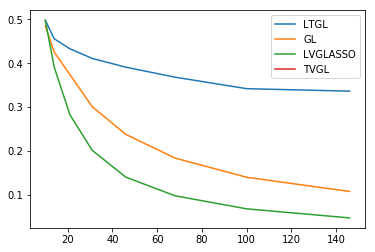

In [81]:
mm = dff.xs("F1score", level='score', axis=1).xs(100, level='time')
for x in mm.index:
    plt.plot(mm.xs(x))
# plt.xscale('log')
plt.legend()
# plt.ylim([0.597,0.600])

In [82]:
mm

dim,10,14,21,31,46,68,100,146,215,316
method,,,,,,,,,,
LTGL,0.498252,0.455931,0.433133,0.411031,0.39111,0.368304,0.342053,0.336448,NaN,NaN
GL,0.485333,0.425253,0.374195,0.300771,0.237664,0.183672,0.139813,0.107458,NaN,NaN
LVGLASSO,0.498047,0.390937,0.28251,0.201183,0.140058,0.0975891,0.0678121,0.0471126,NaN,NaN
TVGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
dff.T.to_latex("arr.tex", float_format='%.2f', na_rep='-')

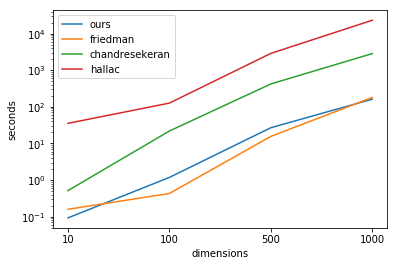

In [178]:
for ff in ['ours', 'friedman', 'chandresekeran', 'hallac']:
    arr = locals()[ff]
    plt.plot(arr.time, label=ff)
plt.yscale('log')
plt.xlabel("dimensions")
plt.ylabel("seconds")
plt.xticks(range(4), ours.n_dim_obs)
plt.legend()
plt.savefig("/home/fede/Dropbox/Latent variables networks/paper formatted/speedup.pdf")

In [60]:
dff.sort_index(level=['score','dim'], axis=1, ascending=[1, 1], inplace=True)

In [50]:
# df_better.to_pickle("dataframe_results.pkl")
# df_better.to_csv("dataframe_results.csv")

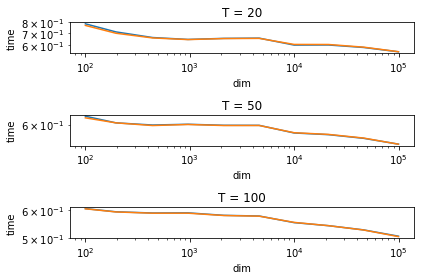

In [44]:
f, ax = plt.subplots(3,1)
for i, tt in enumerate(n_times):
    mm = dff.xs('F1score', level='score', axis=1).xs(tt, level='time')
    for x in mm.index:
        ax[i].plot(mm.xs(x).index ** 2, mm.xs(x).values, label=x)
#     ax[i].legend()
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")
    ax[i].set_xlabel("dim")
    ax[i].set_ylabel("time")
    ax[i].set_title("T = {}".format(tt))

f.tight_layout()

In [84]:
pd.Series(np.arange(5), index=["F1score", "MSE_precision", "MSE_observed",
                             "MSE_latent","mean_rank_error"])

F1score            0
MSE_precision      1
MSE_observed       2
MSE_latent         3
mean_rank_error    4
dtype: int64

In [95]:
idx = pd.IndexSlice
dff.loc[idx['ours', k[1]], idx[:, k[0]]] = 2#[res[x] for x in scores]

In [85]:
sorted(["F1score", "MSE_precision", "MSE_observed",
                             "MSE_latent","mean_rank_error"])

['F1score', 'MSE_latent', 'MSE_observed', 'MSE_precision', 'mean_rank_error']